In [ ]:
import numpy as np

T,H=5,4
hs=np.random.randn(T,H)
a=np.array([0.8, 0.1, 0.03, 0.05, 0.02])

ar=a.reshape(5,1).repeat(4, axis=1)     # 열벡터로 만든 후에 반복함.    근데 ar=a.reshape(5,1)만 하고 hs*ar을 하면 브로드캐스팅이 되어서 계산이 똑같다.
print(ar.shape)                         # (5,4)

t=hs*ar
print(t.shape)                          # (5,4)

c=np.sum(t, axis=0)
print(c.shape)                          # (4,)              이게 맥락 벡터가 됨.

(5, 4)
(5, 4)
(4,)


In [3]:
N,T,H=10,5,4
hs=np.random.randn(N,T,H)
a=np.random.randn(N,T)
ar=a.reshape(N,T,1).repeat(H,axis=2)
#ar=a.reshape(N,T,1) # 브로드캐스트를 사용하는 겨웅

t=hs*ar
print(t.shape)          #(10,5,4)

c=np.sum(t,axis=1)
print(c.shape)          #(10,4)

(10, 5, 4)
(10, 4)


In [ ]:
import sys
sys.path.append('..')
from common.np import *
from common.layers import Softmax


class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        
    def forward(self, hs, a):
        N, T, H = hs.shape
        
        ar= a.reshape(N, T, 1)          #.repeat(H, axis=-1)
        t = hs * ar
        c = np.sum(t, axis=1)
        
        self.cache = (hs, ar)
        return c
    
    def backward(self, dc):
        hs, ar = self.cache
        N, T, H = hs.shape
        dt = dc.reshape(N, 1, H).repeat(T, axis=1)  # sum의 역전파 = repeat             #(N,T,H)가 됨
        dar = dt * hs
        dhs = dt * ar
        da = np.sum(dar, axis=2)  # repeat노드에 대한 역전퍄 = sum              ar은 (N,T,H) 였음-->(N,T)가 됨. 왜냐하면 a가 N,T였음.
        
        return dhs, da

In [ ]:
# 맥락벡터를 구하기 위한 가중치 a를 구하는 방법.

import sys
sys.path.append('..')
from common.layers import Softmax
import numpy as np


N,T,H=10,5,4
hs=np.random.randn(N,T,H)       #encoder의 lstm 계층의 은닉상태 벡터
h=np.random.randn(N,H)          #decoder의 은닉층에서 나온 은닉상태 벡터
hr=h.reshape(N,1,H).repeat(T, axis=1)           #(N,T,H)가 됨.          #hr=h.reshape(N,1,H)            #브로드 캐스트를 사용하는 경우

t=hs*hr
print(t.shape)                                  #(10,5,4)

s=np.sum(t,axis=2)
print(s.shape)                                  #(10,5)

softmax=Softmax()
a=softmax.forward(s)
print(a.shape)                                  #(10,5)

(10, 5, 4)
(10, 5)
(10, 5)


In [6]:
# chap08/attention_layer.py
import sys
sys.path.append('..')
from common.np import *  # import numpy as np
from common.layers import Softmax


class AttentionWeight:
    def __init__(self):
        self.params, self.grads = [], []
        self.softmax = Softmax()
        self.cache = None
        
    def forward(self, hs, h):
        N, T, H = hs.shape

        hr = h.reshape(N, 1, H)#.repeat(T, axis=1)
        t = hs * hr
        s = np.sum(t, axis=2)
        a = self.softmax.forward(s)

        self.cache = (hs, hr)
        return a

    def backward(self, da):                             #a는 (N,T)
        hs, hr = self.cache
        N, T, H = hs.shape

        ds = self.softmax.backward(da)                  #ds의 shape도 (N, T)
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)
        dhs = dt * hr
        dhr = dt * hs
        dh = np.sum(dhr, axis=1)

        return dhs, dh

In [1]:
# chap08/attention_layer.py
import sys
sys.path.append('..')
from common.np import *  # import numpy as np
from common.layers import Softmax


class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()
        self.attention_weight = None

    def forward(self, hs, h):
        a = self.attention_weight_layer.forward(hs, h)
        out = self.weight_sum_layer.forward(hs, a)
        self.attention_weight = a
        return out

    def backward(self, dout):
        dhs0, da = self.weight_sum_layer.backward(dout)
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1
        return dhs, dh


In [ ]:
class TimeAttention:
    def __init__(self):
        self.params, self.grads = [], []
        self.layers = None
        self.attention_weights = None

    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_dec.shape              #T개의 h가 모임.
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weights = []

        for t in range(T):
            layer = Attention()
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:,t,:])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight)

        return out

    def backward(self, dout):
        N, T, H = dout.shape
        dhs_enc = 0
        dhs_dec = np.empty_like(dout)

        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.backward(dout[:, t, :])
            dhs_enc += dhs                                  #repeat의 반대는 sum
            dhs_dec[:,t,:] = dh

        return dhs_enc, dhs_dec


Attention을 적용한 seq2seq를 구현해보자


In [1]:
# chap08/attention_seq2seq.py
import sys
sys.path.append('..')
from common.time_layers import *
from seq2seq import Encoder, Seq2seq
from attention_layer import TimeAttention


class AttentionEncoder(Encoder):                        #기존의 Encoder를 상속.
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        return hs

    def backward(self, dhs):
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

In [ ]:
class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(2*H, V) / np.sqrt(2*H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention()  # Attention 레이어 
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]

        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, enc_hs):
        h = enc_hs[:,-1]                            #hs의 마지막줄줄
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)
        c = self.attention.forward(enc_hs, dec_hs)  # context vector
        out = np.concatenate((c, dec_hs), axis=2)  # context_vector & lstm h_t
        score = self.affine.forward(out)

        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2

        dc, ddec_hs0 = dout[:,:,:H], dout[:,:,H:]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.lstm.backward(ddec_hs)
        dh = self.lstm.dh
        denc_hs[:, -1] += dh                                #마지막 줄에 대해서 ㅇㅇ
        self.embed.backward(dout)

        return denc_hs

    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1]
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))

            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)

        return sampled

In [5]:
a=np.array([[[1,2,3],
   [3,4,5],
   [6,7,8]],
   [[9,10,11],
   [12,13,14],
   [15,16,17]]])
a.shape

a[:,-1]

array([[ 6,  7,  8],
       [15, 16, 17]])

In [6]:
class AttentionSeq2seq(Seq2seq):                                    #Seq2seq상속속
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 4.06
| 에폭 1 |  반복 151 / 351 | 시간 35[s] | 손실 1.64
| 에폭 1 |  반복 301 / 351 | 시간 71[s] | 손실 1.06
Q 10/15/94                     
T 994-10-15
X 973-03-06
---
Q thursday, november 13, 2008  
T 008-11-13
X 004-03-06
---
Q Mar 25, 2003                 
T 003-03-25
X 004-03-06
---
Q Tuesday, November 22, 2016   
T 016-11-22
X 004-03-06
---
Q Saturday, July 18, 1970      
T 970-07-18
X 973-03-06
---
Q october 6, 1992              
T 992-10-06
X 973-03-06
---
Q 8/23/08                      
T 008-08-23
X 004-03-06
---
Q 8/30/07                      
T 007-08-30
X 004-03-06
---
Q 10/28/13                     
T 013-10-28
X 004-03-06
---
Q sunday, november 6, 2016     
T 016-11-06
X 004-03-06
---
정확도 0.000%
| 에폭 2 |  반복 1 / 351 | 시간 0[s] | 손실 1.04
| 에폭 2 |  반복 151 / 351 | 시간 35[s] | 손실 1.02
| 에폭 2 |  반복 301 / 351 | 시간 69[s] | 손실 0.80
Q 10/15/94                     
T 994-10-15
O 994-10-15
---
Q thursday, november 13, 2008  
T 008-11-13
O 008-11-13
---
Q Mar 25, 2

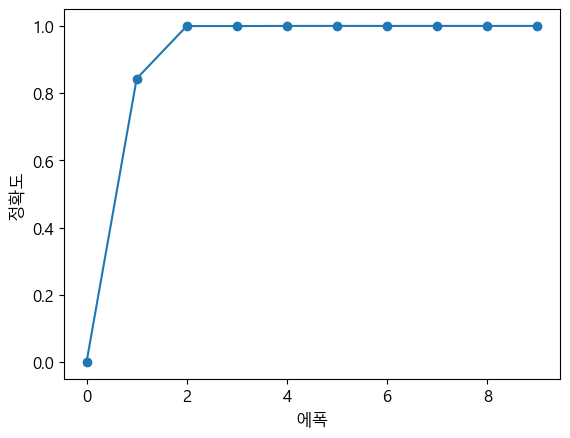

In [2]:

import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as fm
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
plt.rc('font', family=font_name, size=12)
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from attention_seq2seq import AttentionSeq2seq
from seq2seq import Seq2seq
from peeky_seq2seq import PeekySeq2seq


# 데이터 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 문장 반전
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
# model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad, eval_interval=150)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=True)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('정확도 %.3f%%' % (acc * 100))


model.save_params()

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(-0.05, 1.05)
plt.show()

In [ ]:
exit()

: 